In [12]:
import argparse
import os
import re
import matplotlib.pyplot as plt
from datetime import datetime as dt

from image import load_image
from camera_model import CameraModel

from math import sin, cos, tan
import numpy as np
import cv2 as cv

from keras.models import model_from_json

In [2]:
models_dir = "./extrinsics"
img_dir = "/home/user/Downloads/sample_small/stereo/centre"

cam_model = CameraModel(models_dir, img_dir)


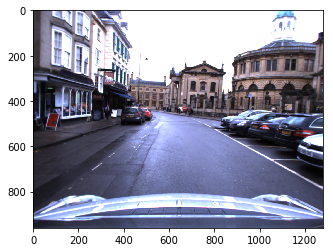

In [3]:
filename = os.path.join(img_dir, "1418381798139171.png")
img = load_image(filename, cam_model)
img = np.round(img).astype(int)
cv.imwrite("test_img.png", img)
plt.imshow(img)
plt.show()

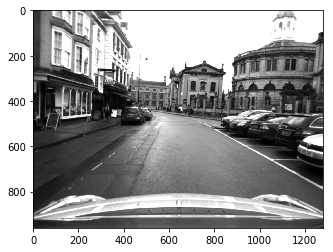

In [4]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

gray_img = rgb2gray(img)
plt.imshow(gray_img, cmap='gray')
plt.show()

# NeuralNet Stuff

In [5]:
# Get BINS_EDGE
BINS_EDGE = np.load("./nn_data/s1p10_bins_edge.npy")

# Get model prediction (kind of cheating to accelerate model demotration)
NUM_LABELS = 10
NUM_CLASSES = len(BINS_EDGE) - 1

In [6]:
MODEL_DIR = "./nn_data/"
MODEL_NAME = "ext_bottom_half_s1p10_model_2019_06_05_19_49"

with open(MODEL_DIR + "%s.json" % MODEL_NAME, 'r') as json_file:
    loaded_model_json = json_file.read()
model = model_from_json(loaded_model_json)

model.load_weights(MODEL_DIR + "%s.h5" % MODEL_NAME)
print("Loaded model from disk")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded model from disk


In [42]:
# Get images name
img_list = []
for (dirpath, dirnames, filenames) in os.walk(img_dir):
    img_list.extend(filenames)
    break
img_list.sort()

In [45]:
filter_img_list = []
for name in img_list:
    if '._' not in name:
        filter_img_list.append(name)

In [49]:
X = np.zeros((len(filter_img_list), 200, 200, 1))
for i, name in enumerate(filter_img_list):
    filename = os.path.join(img_dir, name)
    _img = load_image(filename, cam_model)
    _img = np.round(_img).astype(int)
    
    # convert to gray scale
    _gray_img = rgb2gray(_img)
    
    # get bottom half
    bottom_half = _gray_img[int(0.5 * _gray_img.shape[0]) :, :]

    # down sample & reshape image
    __img = np.float32(cv.resize(bottom_half, (200, 200), interpolation=cv.INTER_AREA))
    if len(__img.shape) == 2:
        __img = __img.reshape((200, 200, 1))

    # store image to X
    X[i, :, :, :] = __img

In [50]:
y_hat_list = model.predict(X, verbose=1)

49/49 [==============================] - 0s 5ms/step


In [51]:
y_hat_list[0].shape

(49, 114)

In [52]:
if not os.isfile('small_sample_prediction.npy'):
    np.save('small_sample_prediction.npy', y_hat_list)

In [15]:
def one_hot_to_angle(one_hot_arr):
    """
    Decode one hot encoded vector to get angle
    
    Input:
        one_hot_arr (np.ndarray): shape (1, num_classes)
        bins_edge (np.ndarray): shape (1, num_classes + 1)
    """
    angle_id = np.argmax(one_hot_arr)
    if angle_id < NUM_CLASSES:
        return (BINS_EDGE[angle_id] + BINS_EDGE[angle_id + 1]) / 2.
    else:
        return BINS_EDGE[angle_id]
    

def trans_2d(phi, s):
    """
    Generate 2D homogeneous transformation matrix given phi is the angle of rotation around z-axis
    and s the arc-length of the motion represented by the transformation
    
    Input
        phi (float): rotation angle in radian
        s (float): arc-length
    
    Return
        np.ndarray shape (3 x 2)
    """
    if abs(phi) < 1e-4:
        return np.array([[1, 0, s],
                         [0, 1, 0],
                         [0, 0, 1]])
    else:
        R = s / phi  # radius of rotation
        return np.array([[cos(phi), -sin(phi),  R * sin(phi)],
                         [sin(phi),  cos(phi),  R * (1 - cos(phi))],
                         [0,                0,  1]])
        

def steering_angle_to_way_pts(y_hat, s=2.0, L=3.7):
    """
    Convert an array of steering angles to an array of way points
    
    Input
        y_hat (list): each element is np.ndarray shape (1, NUM_LABELS)
        s (float): arc-length
        L (float): car length
        
    Output
        np.ndarray, shape(2, NUM_LABELS) each column is coordinate of car's tip i*2meter away 
        in frame attached to center of rear axel at the current iamge frame
    """

    # Decode pred_y to get a sequence of steering angle
    pred_sequence = [one_hot_to_angle(y_hat[i]) for i in range(NUM_LABELS)]
    
    # homogeneous coordinate of car's tip in any local frame
    iLi = np.array([[L, 0, 1]]).T 
    
    # initilize
    way_pts = np.zeros((3, NUM_LABELS))  # 3 rows, cuz of homogeneous coordinate
    oTi = np.eye(3)
    for i, angle in enumerate(pred_sequence):
        # calculate phi
        phi = s * tan(angle) / L
        # construct oTi
        oTi = oTi.dot(trans_2d(phi, s))
        # calculate oLi
        oLi = oTi.dot(iLi)
        # store oLi
        way_pts[:, i] = oLi.squeeze() 
        
    return pred_sequence, way_pts[:2, :]

In [16]:
y_hat = [y_hat_list[j][0, :] for j in range(NUM_LABELS)]
# get way points for the tip of the car
pred_sequence, way_pts = steering_angle_to_way_pts(y_hat)

In [19]:
way_pts

array([[  5.69995142e+00,   7.69977599e+00,   9.69942923e+00,
          1.16988666e+01,   1.36980437e+01,   1.56969160e+01,
          1.76954389e+01,   1.96935681e+01,   2.16912591e+01,
          2.36884673e+01],
       [ -2.21710582e-02,  -5.37761296e-02,  -9.48145110e-02,
         -1.45285289e-01,  -2.05187341e-01,  -2.74519333e-01,
         -3.53279724e-01,  -4.41466759e-01,  -5.39078478e-01,
         -6.46112707e-01]])

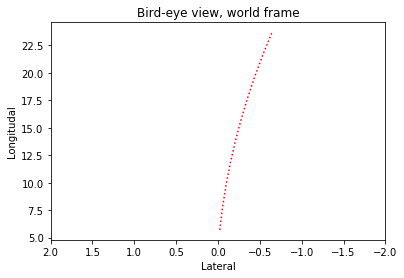

In [34]:
plt.plot(way_pts[1, :], way_pts[0, :], 'r:')
plt.xlim(2, -2)
plt.title("Bird-eye view, world frame")
plt.ylabel("Longitudal")
plt.xlabel("Lateral")
plt.show()

In [23]:
# Transform way points to camera frame
cTw = np.array([[1,  0,  0, -1.72],
                [0, -1,  0, 0.12],
                [0,  0, -1, 1.2]])

cam_way_pts = np.zeros((3, way_pts.shape[1]))
for i in range(way_pts.shape[1]):
    world_pt = np.array([[way_pts[0, i], way_pts[1, i], 0, 1]])
    cam_way_pts[:, i] = cTw.dot(world_pt.T).squeeze()

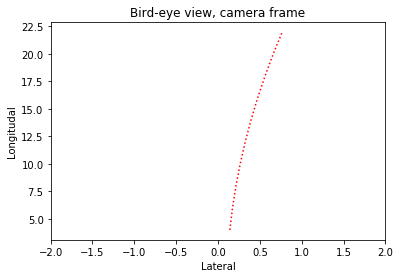

In [35]:
plt.plot(cam_way_pts[1, :], cam_way_pts[0, :], 'r:')
plt.xlim(-2, 2)
plt.title("Bird-eye view, camera frame")
plt.ylabel("Longitudal")
plt.xlabel("Lateral")
plt.show()

In [26]:
uv, _ = cam_model.project(cam_way_pts, img.shape)
uv = np.round(uv).astype(int)

array([[678, 672, 670, 669, 670, 671, 672, 674, 676, 677],
       [775, 678, 630, 600, 581, 567, 557, 549, 542, 537]])

In [27]:
for i in range(uv.shape[1]-1):
    p1 = (uv[0, i], uv[1, i]) 
    p2 = (uv[0, i + 1], uv[1, i + 1])
    cv.line(gray_img, p1, p2, (0, 255, 0), 10)

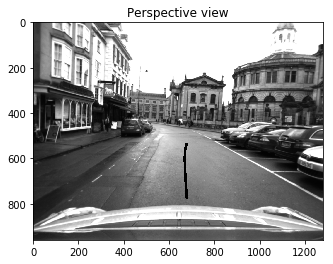

In [33]:
plt.imshow(gray_img, cmap='gray')
plt.title("Perspective view")
plt.show()